### Individual sample Figure 

- Model AuROC
- CNV

In [1]:
### Version checks
import numpy as np
import glob

from pyfaidx import Fasta
fasta_seq=Fasta('/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')

import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy.stats
from pybedtools import BedTool

### sample wise model auroc

In [2]:
import re
df = pd.DataFrame()
df_auroc = pd.DataFrame()
outdir = "/illumina/scratch/deep_learning/akumar22/TCGA/brca_samplewise_prejitter/"
cancer_to_auroc = {}
for cancer_name in [f"BRCA{x}" for x in range(10,26)]:
    print(cancer_name)
    avg_auroc= []
    avg_auprc = []
    for fold in range(5):
        
        logfile = f"{outdir}/{cancer_name}/fold_{fold}/{cancer_name}_prejitter_fold{fold}.txt"
        with open(logfile,"r") as f:
            filter1 = re.compile("AUROC")
            filter2 = re.compile("AUPRC")
            auroc = 0.0 
            for line in f.readlines(): ### get the last occurrence                                   
                if filter1.match(line): 
                    auroc = float(re.findall("\d+\.\d+", line)[0])
                    print(fold,auroc)
                if filter2.match(line): 
                    auprc = float(re.findall("\d+\.\d+", line)[0])
            avg_auprc.append(auprc)
            avg_auroc.append(auroc)   
            
            df_auroc.loc[fold,cancer_name] = auroc

    assert len(avg_auroc) == 5
    print(np.mean(avg_auroc))
    print(avg_auroc)
    cancer_to_auroc[cancer_name] = np.mean(avg_auroc)
    df.loc[cancer_name,"AuROC"] = np.mean(avg_auroc)
    df.loc[cancer_name,"AuPRC"] = np.mean(np.mean(avg_auprc))

df
    

BRCA10
0 0.8875343550272825
1 0.8182092760084403
2 0.8787308426141185
3 0.8845677475468108
4 0.8477151431672605
0.8633514728727825
[0.8875343550272825, 0.8182092760084403, 0.8787308426141185, 0.8845677475468108, 0.8477151431672605]
BRCA11
0 0.8214852318454956
1 0.8499048235198723
2 0.811054960986686
3 0.8875467277458087
4 0.8810866978984497
0.8502156883992626
[0.8214852318454956, 0.8499048235198723, 0.811054960986686, 0.8875467277458087, 0.8810866978984497]
BRCA12
0 0.8161727697630015
1 0.8797510860075752
2 0.8896838356564813
3 0.8771457477386695
4 0.8707701084154991
0.8667047095162455
[0.8161727697630015, 0.8797510860075752, 0.8896838356564813, 0.8771457477386695, 0.8707701084154991]
BRCA13
0 0.8381695672838978
1 0.8509541714024564
2 0.8790433624711609
3 0.8790948638728512
4 0.8498811101172414
0.8594286150295215
[0.8381695672838978, 0.8509541714024564, 0.8790433624711609, 0.8790948638728512, 0.8498811101172414]
BRCA14
0 0.8753012111570107
1 0.908534635131723
2 0.8888647674686165
3 0.8

,AuROC,AuPRC
BRCA10,0.863351,0.872027
BRCA11,0.850216,0.847964
BRCA12,0.866705,0.869433
BRCA13,0.859429,0.867912
BRCA14,0.879747,0.870441
BRCA15,0.916940,0.914590
BRCA16,0.902609,0.900755
BRCA17,0.875677,0.869885
BRCA18,0.877791,0.873183
BRCA19,0.836852,0.838734


In [3]:
df_auroc.to_excel("auroc_brca.xlsx",index=None)

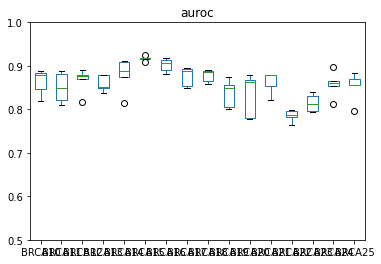

In [3]:
import matplotlib
plt.rcParams["figure.figsize"]=20,10
matplotlib.rcParams['pdf.fonttype']=42
fig,ax=plt.subplots()
df_auroc.boxplot(ax=ax)
ax.set_title("auroc")
ax.set_xticks(ax.get_xticks(),rotation=90)
ax.grid(False)
ax.set_ylim(0.5,1.0)
fig.savefig(f'auroc_brca.pdf',dpi=1200)
plt.show()

### luminal/basal?

In [4]:
brca_type_map = ["LumA","HER2c","LumBc","HER2c","BASALc","LumA","BASAL","HER2+","HER2+","HER2","LumAc","HER2","LumBc","BASAL","BASALc","BASAL"]
brca_type_map = dict(zip([f"BRCA{x}" for x in range(10,26)],brca_type_map))


In [5]:
df=pd.DataFrame.from_dict(brca_type_map.items())
df.columns =["sample","type"]
df

,sample,type
0,BRCA10,LumA
1,BRCA11,HER2c
2,BRCA12,LumBc
3,BRCA13,HER2c
4,BRCA14,BASALc
5,BRCA15,LumA
6,BRCA16,BASAL
7,BRCA17,HER2+
8,BRCA18,HER2+
9,BRCA19,HER2


### sample wise cnv

In [6]:
cnv_files = ["scATAC_BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X009_S01_B1_T1.arrow",
"scATAC_BRCA_11D015DD_1250_48BC_8B5D_3262C97F164B_X007_S02_B1_T1.arrow",
"scATAC_BRCA_14AD76EE_12F9_40B3_8DCD_4A256E02CF8D_X003_S02_B1_T1.arrow",
"scATAC_BRCA_1D939DC3_EF0C_40BF_BC60_8C5D46345265_X004_S02_B1_T1.arrow",
"scATAC_BRCA_2A65DC63_F8CC_4EF4_AB23_3F5FD880FB5E_X010_S02_B1_T1.arrow",
"scATAC_BRCA_5C54B79C_DA02_4B22_9FC2_3D61BFFC5559_X011_S02_B1_T1.arrow",
"scATAC_BRCA_7C6A3AE4_E2EA_42B3_B3F1_81C19E6F2170_X005_S02_B1_T1.arrow",
"scATAC_BRCA_8D1E6006_85CB_484A_8B5C_30766D90137B_X001_S01_B1_T1.arrow",
"scATAC_BRCA_8D1E6006_85CB_484A_8B5C_30766D90137B_X003_S03_B1_T2.arrow",
"scATAC_BRCA_94AF19F0_1F2A_41EC_8CB6_96C76227811F_X013_S01_B1_T1.arrow",
"scATAC_BRCA_A91AADEA_8299_46D9_A250_76896D690AFD_X006_S02_B1_T1.arrow",
"scATAC_BRCA_C147AAD5_A8F1_41D5_8709_21820BE50902_X008_S02_B1_T1.arrow",
"scATAC_BRCA_C9C8D426_A3FD_4455_89A9_768BC01D66A9_X009_S02_B1_T1.arrow",
"scATAC_BRCA_CB96A542_7AC1_4FEC_A5D2_458D8EEDC6C4_X013_S06_B1_T1.arrow",
"scATAC_BRCA_CC102C17_C1CA_427A_8C7D_D3E79748A0CD_X012_S07_B1_T1.arrow",
"scATAC_BRCA_DD69EDE9_142D_46E2_AA06_58D07D3230FB_X014_S08_B1_T1.arrow"]

brca_samples = [f"BRCA{x}" for x in range(10,26)]
brca_to_cnv_file = dict(zip(brca_samples, cnv_files))

In [7]:
brca_to_cnv_file

{'BRCA10': 'scATAC_BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X009_S01_B1_T1.arrow',
 'BRCA11': 'scATAC_BRCA_11D015DD_1250_48BC_8B5D_3262C97F164B_X007_S02_B1_T1.arrow',
 'BRCA12': 'scATAC_BRCA_14AD76EE_12F9_40B3_8DCD_4A256E02CF8D_X003_S02_B1_T1.arrow',
 'BRCA13': 'scATAC_BRCA_1D939DC3_EF0C_40BF_BC60_8C5D46345265_X004_S02_B1_T1.arrow',
 'BRCA14': 'scATAC_BRCA_2A65DC63_F8CC_4EF4_AB23_3F5FD880FB5E_X010_S02_B1_T1.arrow',
 'BRCA15': 'scATAC_BRCA_5C54B79C_DA02_4B22_9FC2_3D61BFFC5559_X011_S02_B1_T1.arrow',
 'BRCA16': 'scATAC_BRCA_7C6A3AE4_E2EA_42B3_B3F1_81C19E6F2170_X005_S02_B1_T1.arrow',
 'BRCA17': 'scATAC_BRCA_8D1E6006_85CB_484A_8B5C_30766D90137B_X001_S01_B1_T1.arrow',
 'BRCA18': 'scATAC_BRCA_8D1E6006_85CB_484A_8B5C_30766D90137B_X003_S03_B1_T2.arrow',
 'BRCA19': 'scATAC_BRCA_94AF19F0_1F2A_41EC_8CB6_96C76227811F_X013_S01_B1_T1.arrow',
 'BRCA20': 'scATAC_BRCA_A91AADEA_8299_46D9_A250_76896D690AFD_X006_S02_B1_T1.arrow',
 'BRCA21': 'scATAC_BRCA_C147AAD5_A8F1_41D5_8709_21820BE50902_X008_S02_B1_T1.

In [8]:
def get_cancer_peak_info(cancer_name):
    print(cancer_name)
    
    ### read the peak file
    peakfile = f"/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/peaks_individuals/{cancer_name}_peakset.csv"
    peak_df = pd.read_csv(peakfile)[["seqnames","start","end"]]
    
    
    ### read cnv file
    cf = brca_to_cnv_file[cancer_name]
    sample_name = "_".join(cf.split("_")[2:-4])
    cnv_fname = f"/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/{sample_name}.csv"
    print("cnv file",cnv_fname)
    if not os.path.exists(cnv_fname):
        print(f"{cnv_fname} not found")
        return
    cnv_df = pd.read_csv(cnv_fname)[["Chromosome","Start","End","Copy_Number"]]
    
    
    ### intersect peak and cnv
    peak_cnv_df = BedTool.from_dataframe(peak_df).intersect(BedTool.from_dataframe(cnv_df), wa=True, wb=True).to_dataframe()
    peak_cnv_df.columns = ["seqnames","start","end","Chromosome","Start","End","copy_number"]
    peak_cnv_df = peak_cnv_df[["seqnames","start","end","copy_number"]]
    assert not len(peak_cnv_df[peak_cnv_df["copy_number"].isna()])
    peak_cnv_df["copy_number"] = peak_cnv_df["copy_number"].astype(int)

    #### load the peak scores
    outdir = "/illumina/scratch/deep_learning/akumar22/TCGA/brca_samplewise_prejitter/"
    for fold_idx in range(5):
        ### read the fold
        preds_df = pd.read_csv(f"{outdir}/{cancer_name}/fold_{fold_idx}/peak_preds.csv")
        preds_df = preds_df.drop(["gc_150","gc_250","gc_500","gc_1364"],axis=1)
        ### make the peaksize 500 preserving the summit
        flank = (1364-500)//2
        preds_df["start"] += flank
        preds_df["end"] = preds_df["start"] + 500
        ### merge with previous folds and cnv information
        len_before = peak_cnv_df.shape[0]
        peak_cnv_df = pd.merge(peak_cnv_df,preds_df,how="left")
        assert peak_cnv_df.shape[0] == len_before
    peak_cnv_df["model_avg"] = (peak_cnv_df["preds_0"] + peak_cnv_df["preds_1"] + peak_cnv_df["preds_2"] + peak_cnv_df["preds_3"] + peak_cnv_df["preds_4"])/5    
    
    
    ### load the read counts
    reads_df = pd.read_csv(f"/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/individualbrca_peakcounts/{cancer_name}_peakcounts.csv")[["seqnames","start","end","counts"]]
    peak_cnv_df_reads = peak_cnv_df.merge(reads_df,how="left")
    assert peak_cnv_df_reads.shape[0] == peak_cnv_df.shape[0]
    assert not len(peak_cnv_df_reads[peak_cnv_df_reads["counts"].isna()])
    peak_cnv_df_reads["counts"] = peak_cnv_df_reads["counts"].astype(int)
    
    return peak_cnv_df_reads


In [9]:
brca_samples = [f"BRCA{x}" for x in [10,12,15,20,22,13,17,18,19,11,14,16,21,23,24,25]] ### custom order

In [17]:
### per fold analysis
df1 = pd.DataFrame()
df2 = pd.DataFrame()
normalized_read_thresh = 30

df_stats = pd.DataFrame()

outdir = "/illumina/scratch/deep_learning/akumar22/TCGA/brca_samplewise_prejitter/"
for cancer_name in brca_samples:
    merged_master = get_cancer_peak_info(cancer_name)
    ### remove copy number 0 (ideally mustnt remove anything)
    if merged_master is None:
        print(f"skipping {cancer_name}")
        continue
    
    print(len(merged_master))
    merged_master = merged_master[merged_master["copy_number"]!=0]
    merged_master["normalized_reads"] = merged_master["counts"] / merged_master["copy_number"]
    print(len(merged_master))
    
    merged_master_lt10 = merged_master[(merged_master["normalized_reads"]>normalized_read_thresh)]
    print(len(merged_master_lt10))    
    
    df_stats.loc[cancer_name,"total non-zero cnv peaks"] = len(merged_master)
    df_stats.loc[cancer_name,f"normalized read > {normalized_read_thresh}"] = len(merged_master_lt10)

    for fold in range(5):
        ### all peaks
        r,pval = scipy.stats.spearmanr(merged_master[f"preds_{fold}"],merged_master["copy_number"])
        df1.loc[fold,cancer_name] = r

        ###
        r,pval = scipy.stats.spearmanr(merged_master_lt10[f"preds_{fold}"],merged_master_lt10["copy_number"])
        df2.loc[fold,cancer_name] = r
   

BRCA10
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/08499A64_3FD8_4E62_AF08_3C66AF93CAE7.csv
108723
108723
105665
BRCA12
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/14AD76EE_12F9_40B3_8DCD_4A256E02CF8D.csv
100105
100102
90958
BRCA15
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/5C54B79C_DA02_4B22_9FC2_3D61BFFC5559.csv
104459
104459
104422
BRCA20
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/A91AADEA_8299_46D9_A250_76896D690AFD.csv
84191
84189
46630
BRCA22
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/C9C8D426_A3FD_4455_89A9_768BC01D66A9.csv
144461
144461
140799
BRCA13
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/1D939DC3_EF0C_40BF_BC60_8C5D46345265.csv
104320
104319
97097
BRCA17
cnv file /illu

In [14]:
df_stats

,total non-zero cnv peaks,normalized read > 30
BRCA10,108723.0,105665.0
BRCA12,100102.0,90958.0
BRCA15,104459.0,104422.0
BRCA20,84189.0,46630.0
BRCA22,144461.0,140799.0
BRCA13,104319.0,97097.0
BRCA17,132029.0,125578.0
BRCA18,75231.0,73242.0
BRCA19,104715.0,76958.0
BRCA14,90109.0,89637.0


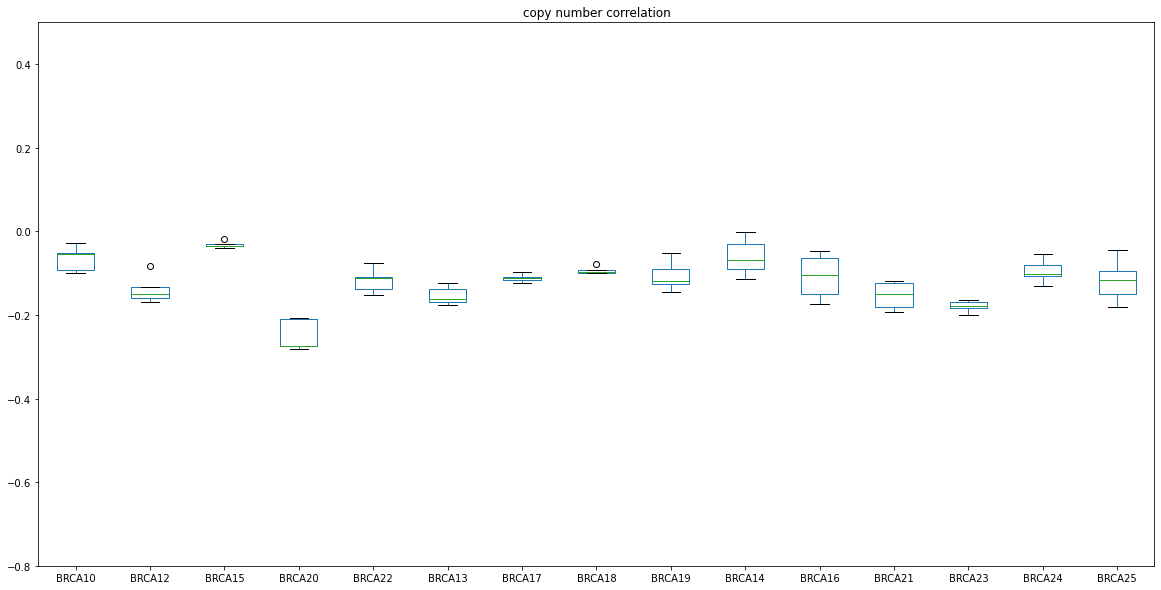

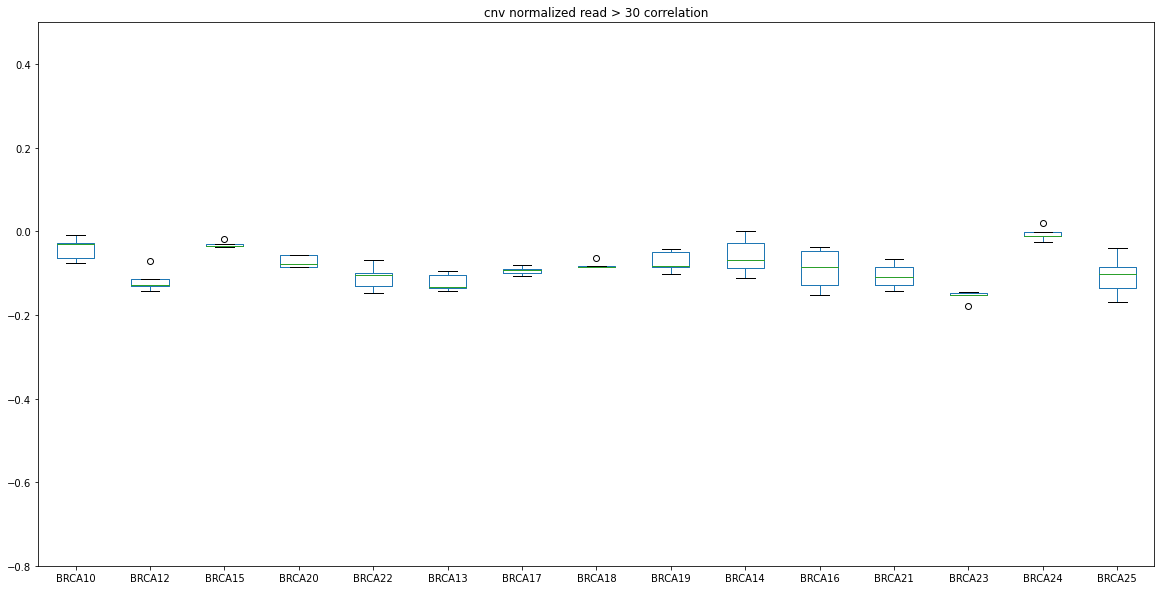

In [13]:
     
import matplotlib
plt.rcParams["figure.figsize"]=20,10
matplotlib.rcParams['pdf.fonttype']=42

fig,ax=plt.subplots()
df1.boxplot(ax=ax)
ax.set_title("copy number correlation")
ax.set_xticks(ax.get_xticks(),rotation=90)
ax.grid(False)
ax.set_ylim(-0.8,0.5)
plt.savefig(f'cnv.pdf',dpi=1200)
plt.show()

fig,ax=plt.subplots()
df2.boxplot(ax=ax)
ax.set_title(f"cnv normalized read > {normalized_read_thresh} correlation")
ax.set_xticks(ax.get_xticks(),rotation=0)
ax.grid(False)
ax.set_ylim(-0.8,0.5)
plt.savefig(f'cnv_lt{normalized_read_thresh}.pdf',dpi=1200)
plt.show()

In [14]:
df1

,BRCA10,BRCA12,BRCA15,BRCA20,BRCA22,BRCA13,BRCA17,BRCA18,BRCA19,BRCA14,BRCA16,BRCA21,BRCA23,BRCA24,BRCA25
0,-0.092465,-0.159121,-0.019248,-0.281050,-0.108973,-0.162634,-0.116425,-0.099935,-0.146404,-0.029989,-0.174471,-0.149597,-0.169555,-0.107139,-0.044305
1,-0.100652,-0.082398,-0.035544,-0.273650,-0.112302,-0.123433,-0.098286,-0.077101,-0.125256,-0.090180,-0.150477,-0.123320,-0.184614,-0.131330,-0.094233
2,-0.055003,-0.133466,-0.034775,-0.274464,-0.075229,-0.176232,-0.110566,-0.098646,-0.120002,-0.001135,-0.104478,-0.192676,-0.178343,-0.079831,-0.180577
3,-0.053107,-0.149711,-0.039152,-0.208985,-0.138988,-0.170109,-0.123715,-0.091531,-0.090222,-0.113989,-0.048176,-0.181889,-0.200327,-0.054335,-0.116870
4,-0.028663,-0.168534,-0.030827,-0.208436,-0.153221,-0.138464,-0.108186,-0.097198,-0.052319,-0.069804,-0.062923,-0.118321,-0.164186,-0.102177,-0.150037


In [15]:
df1.to_csv("cnv_foldwise_correlations.csv")

In [16]:
df2

,BRCA10,BRCA12,BRCA15,BRCA20,BRCA22,BRCA13,BRCA17,BRCA18,BRCA19,BRCA14,BRCA16,BRCA21,BRCA23,BRCA24,BRCA25
0,-0.062871,-0.131206,-0.018816,-0.079414,-0.100048,-0.136165,-0.099002,-0.085830,-0.102599,-0.027845,-0.151608,-0.109228,-0.151997,-0.024737,-0.039363
1,-0.075197,-0.071706,-0.034561,-0.086044,-0.103635,-0.095713,-0.079708,-0.063454,-0.082607,-0.087862,-0.128178,-0.086322,-0.151831,-0.010283,-0.085457
2,-0.029360,-0.113434,-0.034173,-0.084284,-0.069325,-0.143603,-0.092558,-0.084722,-0.085625,-0.000056,-0.085472,-0.142999,-0.148307,-0.011710,-0.168017
3,-0.028140,-0.129129,-0.038376,-0.055934,-0.130462,-0.133931,-0.106662,-0.085402,-0.042411,-0.112003,-0.037650,-0.127699,-0.177755,0.020286,-0.102785
4,-0.008793,-0.143148,-0.030369,-0.057893,-0.147137,-0.105040,-0.089716,-0.083603,-0.048732,-0.067496,-0.046016,-0.067366,-0.145659,-0.002281,-0.135617


In [17]:
df2.to_csv(f"cnv_foldwise_correlations_nrc_gt_{normalized_read_thresh}.csv")

In [18]:
!pwd

/illumina/scratch/deep_learning/akumar22/TCGA/CNV


In [18]:
### per fold analysis
df1 = pd.DataFrame()
df2 = pd.DataFrame()
normalized_read_thresh = 30

df_stats = pd.DataFrame()

outdir = "/illumina/scratch/deep_learning/akumar22/TCGA/brca_samplewise_prejitter/"
for cancer_name in brca_samples:
    merged_master = get_cancer_peak_info(cancer_name)
    ### remove copy number 0 (ideally mustnt remove anything)
    if merged_master is None:
        print(f"skipping {cancer_name}")
        continue
    
    print(len(merged_master))
    merged_master = merged_master[merged_master["copy_number"]!=0]
    merged_master["normalized_reads"] = merged_master["counts"] / merged_master["copy_number"]
    print(len(merged_master))
    
    merged_master_lt10 = merged_master[(merged_master["normalized_reads"]>normalized_read_thresh)]
    print(len(merged_master_lt10))    
    
    df_stats.loc[cancer_name,"total non-zero cnv peaks"] = len(merged_master)
    df_stats.loc[cancer_name,f"normalized read > {normalized_read_thresh}"] = len(merged_master_lt10)

    for fold in range(5):
        ### all peaks
        r,pval = scipy.stats.spearmanr(merged_master[f"preds_{fold}"],merged_master["copy_number"])
        df1.loc[fold,cancer_name] = r

        ###
        r,pval = scipy.stats.spearmanr(merged_master_lt10[f"preds_{fold}"],merged_master_lt10["copy_number"])
        df2.loc[fold,cancer_name] = r
        
    r,pval = scipy.stats.spearmanr(merged_master["model_avg"],merged_master["copy_number"])
    df1.loc[5,cancer_name] = r

    ###
    r,pval = scipy.stats.spearmanr(merged_master_lt10["model_avg"],merged_master_lt10["copy_number"])
    df2.loc[5,cancer_name] = r
   

BRCA10
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/08499A64_3FD8_4E62_AF08_3C66AF93CAE7.csv
108723
108723
105665
BRCA12
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/14AD76EE_12F9_40B3_8DCD_4A256E02CF8D.csv
100105
100102
90958
BRCA15
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/5C54B79C_DA02_4B22_9FC2_3D61BFFC5559.csv
104459
104459
104422
BRCA20
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/A91AADEA_8299_46D9_A250_76896D690AFD.csv
84191
84189
46630
BRCA22
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/C9C8D426_A3FD_4455_89A9_768BC01D66A9.csv
144461
144461
140799
BRCA13
cnv file /illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/1D939DC3_EF0C_40BF_BC60_8C5D46345265.csv
104320
104319
97097
BRCA17
cnv file /illu

In [19]:
df1

,BRCA10,BRCA12,BRCA15,BRCA20,BRCA22,BRCA13,BRCA17,BRCA18,BRCA19,BRCA14,BRCA16,BRCA21,BRCA23,BRCA24,BRCA25
0,-0.092465,-0.159121,-0.019248,-0.281050,-0.108973,-0.162634,-0.116425,-0.099935,-0.146404,-0.029989,-0.174471,-0.149597,-0.169555,-0.107139,-0.044305
1,-0.100652,-0.082398,-0.035544,-0.273650,-0.112302,-0.123433,-0.098286,-0.077101,-0.125256,-0.090180,-0.150477,-0.123320,-0.184614,-0.131330,-0.094233
2,-0.055003,-0.133466,-0.034775,-0.274464,-0.075229,-0.176232,-0.110566,-0.098646,-0.120002,-0.001135,-0.104478,-0.192676,-0.178343,-0.079831,-0.180577
3,-0.053107,-0.149711,-0.039152,-0.208985,-0.138988,-0.170109,-0.123715,-0.091531,-0.090222,-0.113989,-0.048176,-0.181889,-0.200327,-0.054335,-0.116870
4,-0.028663,-0.168534,-0.030827,-0.208436,-0.153221,-0.138464,-0.108186,-0.097198,-0.052319,-0.069804,-0.062923,-0.118321,-0.164186,-0.102177,-0.150037
5,-0.069337,-0.153081,-0.032605,-0.299100,-0.129269,-0.168434,-0.126997,-0.120878,-0.140411,-0.089008,-0.126724,-0.175253,-0.211897,-0.102735,-0.148343


In [20]:
df2

,BRCA10,BRCA12,BRCA15,BRCA20,BRCA22,BRCA13,BRCA17,BRCA18,BRCA19,BRCA14,BRCA16,BRCA21,BRCA23,BRCA24,BRCA25
0,-0.062871,-0.131206,-0.018816,-0.079414,-0.100048,-0.136165,-0.099002,-0.085830,-0.102599,-0.027845,-0.151608,-0.109228,-0.151997,-0.024737,-0.039363
1,-0.075197,-0.071706,-0.034561,-0.086044,-0.103635,-0.095713,-0.079708,-0.063454,-0.082607,-0.087862,-0.128178,-0.086322,-0.151831,-0.010283,-0.085457
2,-0.029360,-0.113434,-0.034173,-0.084284,-0.069325,-0.143603,-0.092558,-0.084722,-0.085625,-0.000056,-0.085472,-0.142999,-0.148307,-0.011710,-0.168017
3,-0.028140,-0.129129,-0.038376,-0.055934,-0.130462,-0.133931,-0.106662,-0.085402,-0.042411,-0.112003,-0.037650,-0.127699,-0.177755,0.020286,-0.102785
4,-0.008793,-0.143148,-0.030369,-0.057893,-0.147137,-0.105040,-0.089716,-0.083603,-0.048732,-0.067496,-0.046016,-0.067366,-0.145659,-0.002281,-0.135617
5,-0.040916,-0.130479,-0.031957,-0.090289,-0.120853,-0.132592,-0.107327,-0.107773,-0.097160,-0.086601,-0.104513,-0.120574,-0.183262,-0.000452,-0.135710


In [21]:
df2.to_excel("cnv_lt30.xlsx",index=None)